In [1]:
import gym
import random
import os
import numpy as np
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense
from keras.optimizers import Adam

Using TensorFlow backend.
/home/david.bertoin/anaconda3/envs/IRT_RL2/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/david.bertoin/anaconda3/envs/IRT_RL2/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [8]:
def create_model(state_size, action_size, learning_rate=0.003, layer_size=24):
    model = Sequential()
    model.add(Dense(layer_size, input_dim=state_size, activation='relu'))
    model.add(Dense(layer_size, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    
    model.compile(loss='mse', optimizer=Adam(learning_rate))
    return model

In [9]:
class Agent():
    
    def __init__(self, env):
        
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.brain = create_model(self.state_size, self.action_size)
        self.memory = deque(maxlen=2000)
        self.exploration_rate = 1.0
        self.exploration_min = 0.01
        self.exploration_decay = 0.995
        self.gamma = 0.95
        
    def next_action(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        actions = self.brain.predict(state)[0]
        #print(actions)
        return np.argmax(actions)
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
                return
        sample_batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in sample_batch:
            target = self.brain.predict(state)
            if not done:
                target[0][action] = reward + self.gamma * np.amax(self.brain.predict(next_state)[0])
            else:
                target[0][action] = reward
            self.brain.fit(state, target, epochs=1, verbose=0)

        self.decay_exploration_rate()
                
    def decay_exploration_rate(self):
        self.exploration_rate = max(self.exploration_min, self.exploration_rate * self.exploration_decay) 
    
    def learn(self, num_episodes, max_step_by_episode=200, batch_size=32):
        scores = []
        for i in range(num_episodes):
            state = np.reshape(env.reset(), [1, self.state_size])
            nb_steps_this_episode = 0
            done = False
            while not done:
                action = self.next_action(state)
                next_state, reward, done, _ = env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                self.remember(state, action, reward, next_state, done)
                nb_steps_this_episode += 1
                if done:
                    break
                state = next_state
            print("episode: %s, nb_steps_this_episode: %s" % (i, nb_steps_this_episode))
            scores.append(nb_steps_this_episode)
            self.replay(batch_size)
        return scores
     

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 0, nb_steps_this_episode: 16
episode: 1, nb_steps_this_episode: 81
episode: 2, nb_steps_this_episode: 52
episode: 3, nb_steps_this_episode: 17
episode: 4, nb_steps_this_episode: 16
episode: 5, nb_steps_this_episode: 21
episode: 6, nb_steps_this_episode: 23
episode: 7, nb_steps_this_episode: 14
episode: 8, nb_steps_this_episode: 14
episode: 9, nb_steps_this_episode: 32
episode: 10, nb_steps_this_episode: 14
episode: 11, nb_steps_this_episode: 14
episode: 12, nb_steps_this_episode: 17
episode: 13, nb_steps_this_episode: 19
episode: 14, nb_steps_this_episode: 15
episode: 15, nb_steps_this_episode: 26
episode: 16, nb_steps_this_episode: 30
episode: 17, nb_steps_this_episode: 31
episode: 18, nb_steps_this_episode: 16
episode: 19, nb_steps_this_episode: 12
episode: 20, nb_steps_this_episode: 10
episode: 21, nb_steps_this_episode: 28
episode: 22, nb_steps_this_episode: 14
episode: 23, n

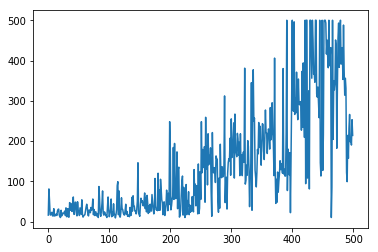

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make('CartPole-v1')
agent = Agent(env)
scores = agent.learn(500)
plt.plot(scores)